# v0.1-NSCLC-PreProcesser

This note book takes you thourgh the steps I have taken so far to preprocess the lung CT scan data from NSCLC. After the Code review section, you can find my relfections for the next steps. The notebooks for *Kaggle's Data Science Bowl 2017* have greatly helped me in understanding the workings of medical imaging data. 

# Code Review

Currently, the aim of this notebook is to in the end create a list of dictionaries where each item holds **patient_ID**, **survival_time** as the labels, and eventually **image_data** value for each patient in the available data. This list can be potentially perserved as a .csv or .json file for future use and learning.

In [5]:
patients_list = []

### imports

In [6]:
import shutil
import pprint
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import json
from skimage import measure, morphology
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
from mpl_toolkits.mplot3d.art3d import Poly3DCollection



%matplotlib inline
pp = pprint.PrettyPrinter(indent=2)
DATA_PATH = os.path.join('.', 'lung_data')

### 1. Rearranging Data's Folder Structure

The original directory structure of the data is messy and hard to navigate. The code here utilizes **os** and **shutil** packages to move the .dcm files from the old structure to a new, more workable one. In the proposed structure, you will find each patient’s full imaging data in an immediate subdirectory. 

In [7]:
# Old Structure: 
# ./ -> classical_names -> NSCLC-Radiomics -> {patient ID} -> 1.3.6.1.4.1.32722... -> 1.3.6.1.4.1.32722... -> *.dcm

# proposed structure: 
# ./ -> lung_data -> {patient ID} -> *.dcm

**You need to be carefull when using the following code blocks. The script will move files from their original directory in a manner not easily reversible**

#### 1.1 First we create the output folder

In [8]:
# Create the output folder
output = DATA_PATH
if not os.path.exists(output):
    os.mkdir(output)

#### 1.2 The data path based on Classical folder namings

In [ ]:
data_path = os.path.join('.', 'classical_names')
data_path = os.path.join(data_path, 'NSCLC-Radiomics')

#### 1.3 Moving Each patient's .dcm files into their respective directory in the output folder


In [ ]:
# We iterate over single patients
for patient in os.listdir(data_path):

    # check to see if actually a patient folder
    if patient.startswith('LUNG1-'):
        patient_path = os.path.join(data_path, patient)

        # iterating patient's subdirectories
        for fol in os.listdir(patient_path):

            # get the directory with all the slices
            if(fol.startswith('1.3.6.1.4.1.3')):

                # prepare for moving the .dcm files by creating a respective output directory
                patient_slices_path = os.path.join(patient_path, fol)
                patient_output = os.path.join(output, patient)
                os.mkdir(patient_output)

                #there is a subdirectory that we need to traverse
                for single_folder in os.listdir(patient_slices_path):
                    if not single_folder.startswith('.'):
                        patient_slices_path = os.path.join(patient_slices_path, single_folder)

                        #move all dcm files to respective output folder
                        for dcm in os.listdir(patient_slices_path):
                            shutil.move(os.path.join(patient_slices_path, dcm), patient_output)

### 2.Creating the patients dictionary

Currently, the aim of this notebook is to create and perserve a list of dictionaries where in each dictionary we get **patient_ID**, 3d imaging data **image_data** and **survival_time** as the choosen label. 

We initialize the dictionary list with patient_IDs and survival_times and later add the image_data

#### 2.1 Retrive patient IDs available to this project

I have decided to work on a smaller subset of all the data available so not to overwhelm my hardware. 

In [9]:
patients_ids = [x for x in os.listdir(DATA_PATH) if not x.startswith('.')]
patients_ids.sort()

In [10]:
pp.pprint(patients_ids)

[ 'LUNG1-001',
  'LUNG1-002',
  'LUNG1-003',
  'LUNG1-004',
  'LUNG1-005',
  'LUNG1-006',
  'LUNG1-007',
  'LUNG1-008',
  'LUNG1-009',
  'LUNG1-010',
  'LUNG1-011',
  'LUNG1-012',
  'LUNG1-013',
  'LUNG1-014',
  'LUNG1-015',
  'LUNG1-016',
  'LUNG1-017',
  'LUNG1-018',
  'LUNG1-019',
  'LUNG1-020',
  'LUNG1-021',
  'LUNG1-022',
  'LUNG1-023',
  'LUNG1-024',
  'LUNG1-025']


#### 2.2 Initializing the dictionary list with IDs and Labels

In [11]:
#patients list is the final product where we have a list, and each element is a:
### dictionary of patient_id, Survival.time as the label, and eventually patient_image

clinical_df = pd.read_csv('NSCLC Radiomics Lung1.clinical-version3-Oct 2019.csv')
for index, row in clinical_df.iterrows():
    if row['PatientID'] in patients_ids:
        this_patient_dict = {'patient_ID': row['PatientID'],
                             'survival_time': row['Survival.time']}
        patients_list.append(this_patient_dict)


In [12]:
pp.pprint(patients_list)

[ {'patient_ID': 'LUNG1-001', 'survival_time': 2165},
  {'patient_ID': 'LUNG1-002', 'survival_time': 155},
  {'patient_ID': 'LUNG1-003', 'survival_time': 256},
  {'patient_ID': 'LUNG1-004', 'survival_time': 141},
  {'patient_ID': 'LUNG1-005', 'survival_time': 353},
  {'patient_ID': 'LUNG1-006', 'survival_time': 173},
  {'patient_ID': 'LUNG1-007', 'survival_time': 137},
  {'patient_ID': 'LUNG1-008', 'survival_time': 77},
  {'patient_ID': 'LUNG1-009', 'survival_time': 131},
  {'patient_ID': 'LUNG1-010', 'survival_time': 2119},
  {'patient_ID': 'LUNG1-011', 'survival_time': 515},
  {'patient_ID': 'LUNG1-012', 'survival_time': 85},
  {'patient_ID': 'LUNG1-013', 'survival_time': 3614},
  {'patient_ID': 'LUNG1-014', 'survival_time': 1247},
  {'patient_ID': 'LUNG1-015', 'survival_time': 1238},
  {'patient_ID': 'LUNG1-016', 'survival_time': 101},
  {'patient_ID': 'LUNG1-017', 'survival_time': 220},
  {'patient_ID': 'LUNG1-018', 'survival_time': 1926},
  {'patient_ID': 'LUNG1-019', 'survival_ti

### 3. Loading a Single Scan

With load_scan function we can load all the slices from a single patient's study into a list of **pydicom dataset objects**

I add **slice_thickness** attribute to each slice's dataset so we have the pixel size in Z direction

In [13]:
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness

        #This was in the code from KNamdar
        if s.AccessionNumber == '':
            s.AccessionNumber = "Blank_Accession_Number"

    return slices

In [14]:
example_scan = load_scan(os.path.join(DATA_PATH, patients_ids[0]))
example_scan[0]['PatientName']

(0010, 0010) Patient's Name                      PN: '2342949070'

### 4. The image pixels

Now that we can load the scans into python, we would like to access the image pixels. 
I have learned that Hounsfield Unit (HU) needs to be taken care of in .dcm images . 
The following function does that for us

In [15]:
# Taking care of Hounsfield Unit (HU)
def get_pixels_hu(slices):

    image = np.stack([s.pixel_array for s in slices])

    # int16 should be enough for the pixel data. We use it to save memory
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0 (in some machines it is set to -2000)
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0

    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)

#### 4.1 Visualizing a single slice in an scan

Run the code below for some visualization

In [16]:
# This number indicates which slice of this patient's scan to be shown
NUM_SLICE = 30

def single_patinet_visualization(patient):
    patient_scan = load_scan(os.path.join(DATA_PATH, patient))
    patient_pixels = get_pixels_hu(patient_scan)
    plt.hist(patient_pixels.flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()

    print(patient_pixels.shape)
    # Show a random slices
    plt.imshow(patient_pixels[NUM_SLICE], cmap=plt.cm.gray)
    plt.show()
    

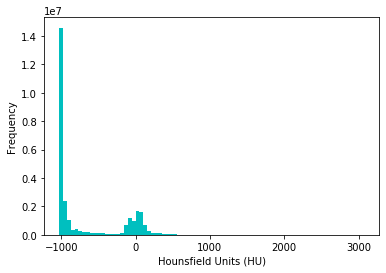

(107, 512, 512)


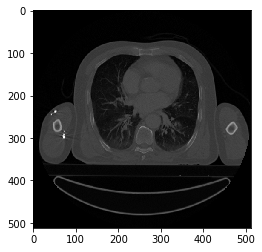

In [17]:
# Arbitrarily visualizing a single patient

single_patinet_visualization(patients_list[2]['patient_ID'])

#### 4.2 One image and One scan for later use

In [18]:
scan = load_scan(os.path.join(DATA_PATH,patients_list[13]['patient_ID']))
image = get_pixels_hu(scan)

***

**In the following blocks I preview the functionality that I have read about and makes sense to me to be important** Some have problems, some result in impractical usage of memory. I have put these here to receive feedback about which one is important to have.  

### 5. Uniform Spacing for resampling

It makes sense that the spatial information in .dcm files is much important than regular image files. Therefore, depending on the slice thickness attribute and pixel spacing attribute in the dicom dataset for each patient, we need to make amendments to have uniform spacing. 


Each full scan is huge in the image size, we have (x, 500, 500) for sizes where x > 100 most of the times. We cannot work with CNNs with such numbers. More in the **Reflections** section

#### 5.1 Default Pixel Space and Slice Thickness

When I run the following code for the current data, we can see that both attributes are mostly the same across the studies. So maybe the next section is not necessary for NSCLC data.

In [19]:
for patient in patients_list:
    print("Patient {}: ".format(patient['patient_ID']))
    scan = load_scan((os.path.join(DATA_PATH, patient['patient_ID'])))
    print("\tSlice Thickness: {}".format(scan[0].SliceThickness))
    print("\tPixel Spacing : {}".format(scan[0].PixelSpacing))


Patient LUNG1-001: 
	Slice Thickness: 3.0
	Pixel Spacing : [0.9765625, 0.9765625]
Patient LUNG1-002: 
	Slice Thickness: 3.0
	Pixel Spacing : [0.9770, 0.9770]
Patient LUNG1-003: 
	Slice Thickness: 3.0
	Pixel Spacing : [0.9770, 0.9770]
Patient LUNG1-004: 
	Slice Thickness: 3.0
	Pixel Spacing : [0.9765625, 0.9765625]
Patient LUNG1-005: 
	Slice Thickness: 3.0
	Pixel Spacing : [0.9770, 0.9770]
Patient LUNG1-006: 
	Slice Thickness: 3.0
	Pixel Spacing : [0.9770, 0.9770]
Patient LUNG1-007: 
	Slice Thickness: 3.0
	Pixel Spacing : [0.9765625, 0.9765625]
Patient LUNG1-008: 
	Slice Thickness: 3.0
	Pixel Spacing : [0.9770, 0.9770]
Patient LUNG1-009: 
	Slice Thickness: 3.0
	Pixel Spacing : [0.9770, 0.9770]
Patient LUNG1-010: 
	Slice Thickness: 3.0
	Pixel Spacing : [0.9770, 0.9770]
Patient LUNG1-011: 
	Slice Thickness: 3.0
	Pixel Spacing : [0.9770, 0.9770]
Patient LUNG1-012: 
	Slice Thickness: 3.0
	Pixel Spacing : [0.9770, 0.9770]
Patient LUNG1-013: 
	Slice Thickness: 3.0
	Pixel Spacing : [0.9765625,

#### 5.2 Uniform space and resample

The following solution was proposed in Kaggle. The output of this function is very big (image is usually shaped as (500+, 500, 500)). 

**I am not using it right now because the spacing of the data appears to be uniform as it is. I have kept this here just in case it was needed**

In [20]:
def resample(image, scan, new_spacing=[1, 1, 1]):
    # Determine current pixel spacing
    #print(scan[0])
    '''
    spacing_list = [scan[0].SliceThickness]
    spacing_list.extend(scan[0].PixelSpacing)
    spacing = np.array(spacing_list, dtype=np.float32)
    '''
    
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

    return image, new_spacing

In [21]:
resampled_data = resample(image, scan)

In [22]:
print("Original Image Shape: {}".format(image.shape))
print("Resampled Image Shape: {}".format(resampled_data[0].shape))

Original Image Shape: (87, 512, 512)
Resampled Image Shape: (261, 500, 500)


### 6. 3D plotting a scan

This following block is borrowed from the data science bowl notebooks. However, the output here is awkward. More work to be done if the feature is important to have.

In [23]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _  = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

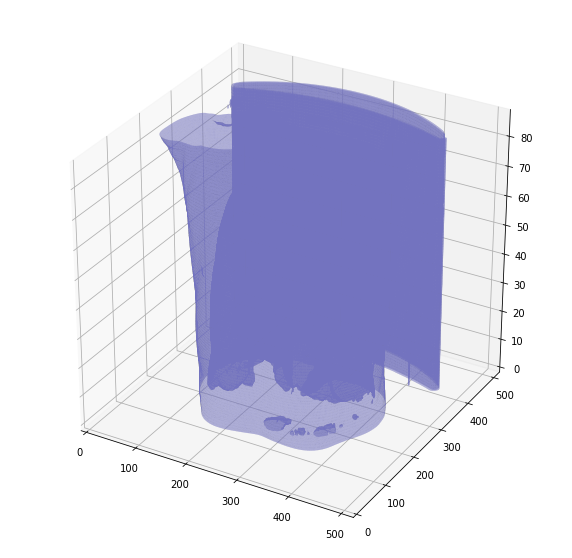

In [24]:
plot_3d(image)

However, there does not seem to be a problem with images. I am not a doctor, so I don't know. One reason for the awkward 3d image before can be the fact that some devices appear to be visible in the following 2d slices.

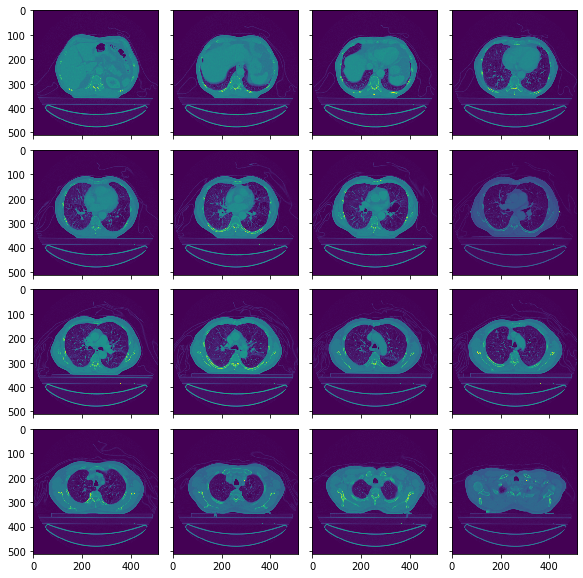

In [25]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(4, 4),  # creates 4 * 4 grid of axes
                 axes_pad=0.2,  # pad between axes in inch.
                 )

for ax, im in zip(grid, image[0:80:5]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()



### 7. Normalizing and Zero Centring

#### 7.1 Normalizing

First we normalize our data. 

I ran through .dcm data and come up with these two numbers as the upper, lower bounds for hu value: 

**MIN**: -1024

**MAX**: 3071

Yet, in my limited research in the topic I read that the important values for lung imaging analysis should be limited to : (Apprantly this is the usually used interval for LUNA16 competition)

**MIN_BOUND** = -1000.0

**MAX_BOUND** = 400.0

In [26]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0

def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [27]:
print("Before:")
print("\t {}".format(np.amax(image)))
print("After:")
normalized_image = normalize(image)
print("\t {}".format(np.amax(normalized_image)))

Before:
	 3071
After:
	 1.0


#### 7.2 Zero Centring

I have come to understand an important aspect of .dcm data is the spatial data in the files. It is important, unlike regualr images, that where the image is situated in 3d space. 

I read that some zero centering can be helpful for CNN design. **I have added the code here for future review**

In [28]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

## Reflections

So far, I have learned basic structure of dicom files and the way we can interact with them through python. 

A list of dictionaries called ```patients_list``` is available for future steps. 

I think the main challange ahead is the size and irregularity of the input data. Right now each patient has a custome number of slices *x* and the image data for each patient ends up being around (x, 500, 500). The issues are: 

1. Input of size (x, 500, 500) is almost impossible to practically deal with
2. We eventually need a fixed shape as the input for a CNN model


#### For problem **1** I can propose the following solution, but I am not sure if it will mess up the spacing features of dicom files which are apparently very important.

In [29]:
def make_image_small(image, IMG_PX_SIZE = 150):  
    return np.array([cv2.resize(im,(IMG_PX_SIZE, IMG_PX_SIZE)) for im in image])

In [30]:
small_image = make_image_small(image)
small_image.shape

(87, 150, 150)

#### For probelm **2**, however, I am not really sure. Each patient has a different number of slices, and I am sure it is important how to choose between them so all patients share an equal number of slices